In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

## Input data

In [2]:
df = pd.read_csv('../Dataset/encoded_data.csv')
df.head(2)

,originalRate,size,baseOccupancy,maxChildOccupancy,maxChildAge,isBreakfastIncluded,isWifiIncluded,isRefundable,hasLivingRoom,starRating,...,PARK,HOSPITAL,MUSEUM,GALLERY,PLACE_OF_WORSHIP,TRAIN_STATION,ZOO,ENTERTAINMENT,GARDEN.1,THEATER
0,1227273,46.0,3,1,5,1,1,1,0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,596694,31.0,2,1,5,0,1,1,0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = df.drop('originalRate', axis=1)
y = df['originalRate']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3592, 313) (898, 313) (3592,) (898,)


## Train data with XGBoost

In [5]:
# Train the data with XGBoost
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror',
    eval_metric='rmse'
)
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### Model Evaluation  

In [6]:
print('Train evaluation')
preds = xg_reg.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds),3))
print('-'*20)

print('Test evaluation')
preds = xg_reg.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds),3))

Train evaluation
RMSE:  202,870
R2:  0.987
--------------------
Test evaluation
RMSE:  886,863
R2:  0.773


## Cross validation using grid search

In [7]:
# Hyperparameter tuning
parameters = {
    'colsample_bytree':[0.7],
    'learning_rate':[0.2],
    'subsample': [0.9],
    'max_depth': [20],
    'min_child_weight': [5],
    'n_estimators': [350],
    'reg_alpha': [3],
    'reg_lambda':[9],
}
# Set up score
scoring = ['neg_root_mean_squared_error', 'r2']

In [8]:
# Set up GridSearchCV
grid = GridSearchCV(
    xg_reg,
    parameters,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=3
    )
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_c...
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0,
                                    reg_alpha=0, reg_lambda=1, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.2],
                         'max_depth': [20], 'min_child_weight': [5],
                         'n_estimators': [350], 'reg_alpha': [3],
                         'reg_lambda': [9], 'subsample': [0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=3)

In [9]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=350, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=9, ...)

In [10]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 20,
 'min_child_weight': 5,
 'n_estimators': 350,
 'reg_alpha': 3,
 'reg_lambda': 9,
 'subsample': 0.9}

### Model Evaluation

In [11]:
print('Train evaluation')
preds = grid.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds),3))
print('-'*20)

print('Test evaluation')
preds = grid.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds),3))

Train evaluation
RMSE:  94,114
R2:  0.997
--------------------
Test evaluation
RMSE:  855,797
R2:  0.789


### Feature importance

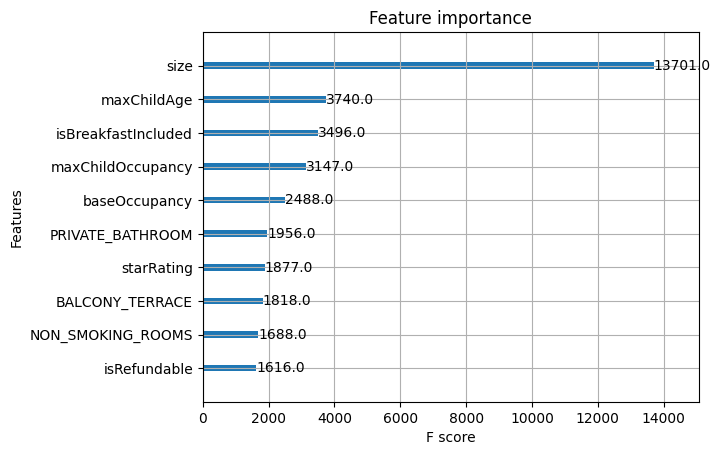

In [12]:
xgb.plot_importance(grid.best_estimator_, max_num_features=10)
plt.savefig('feature_importance.png', dpi=300)

### Tree visualization

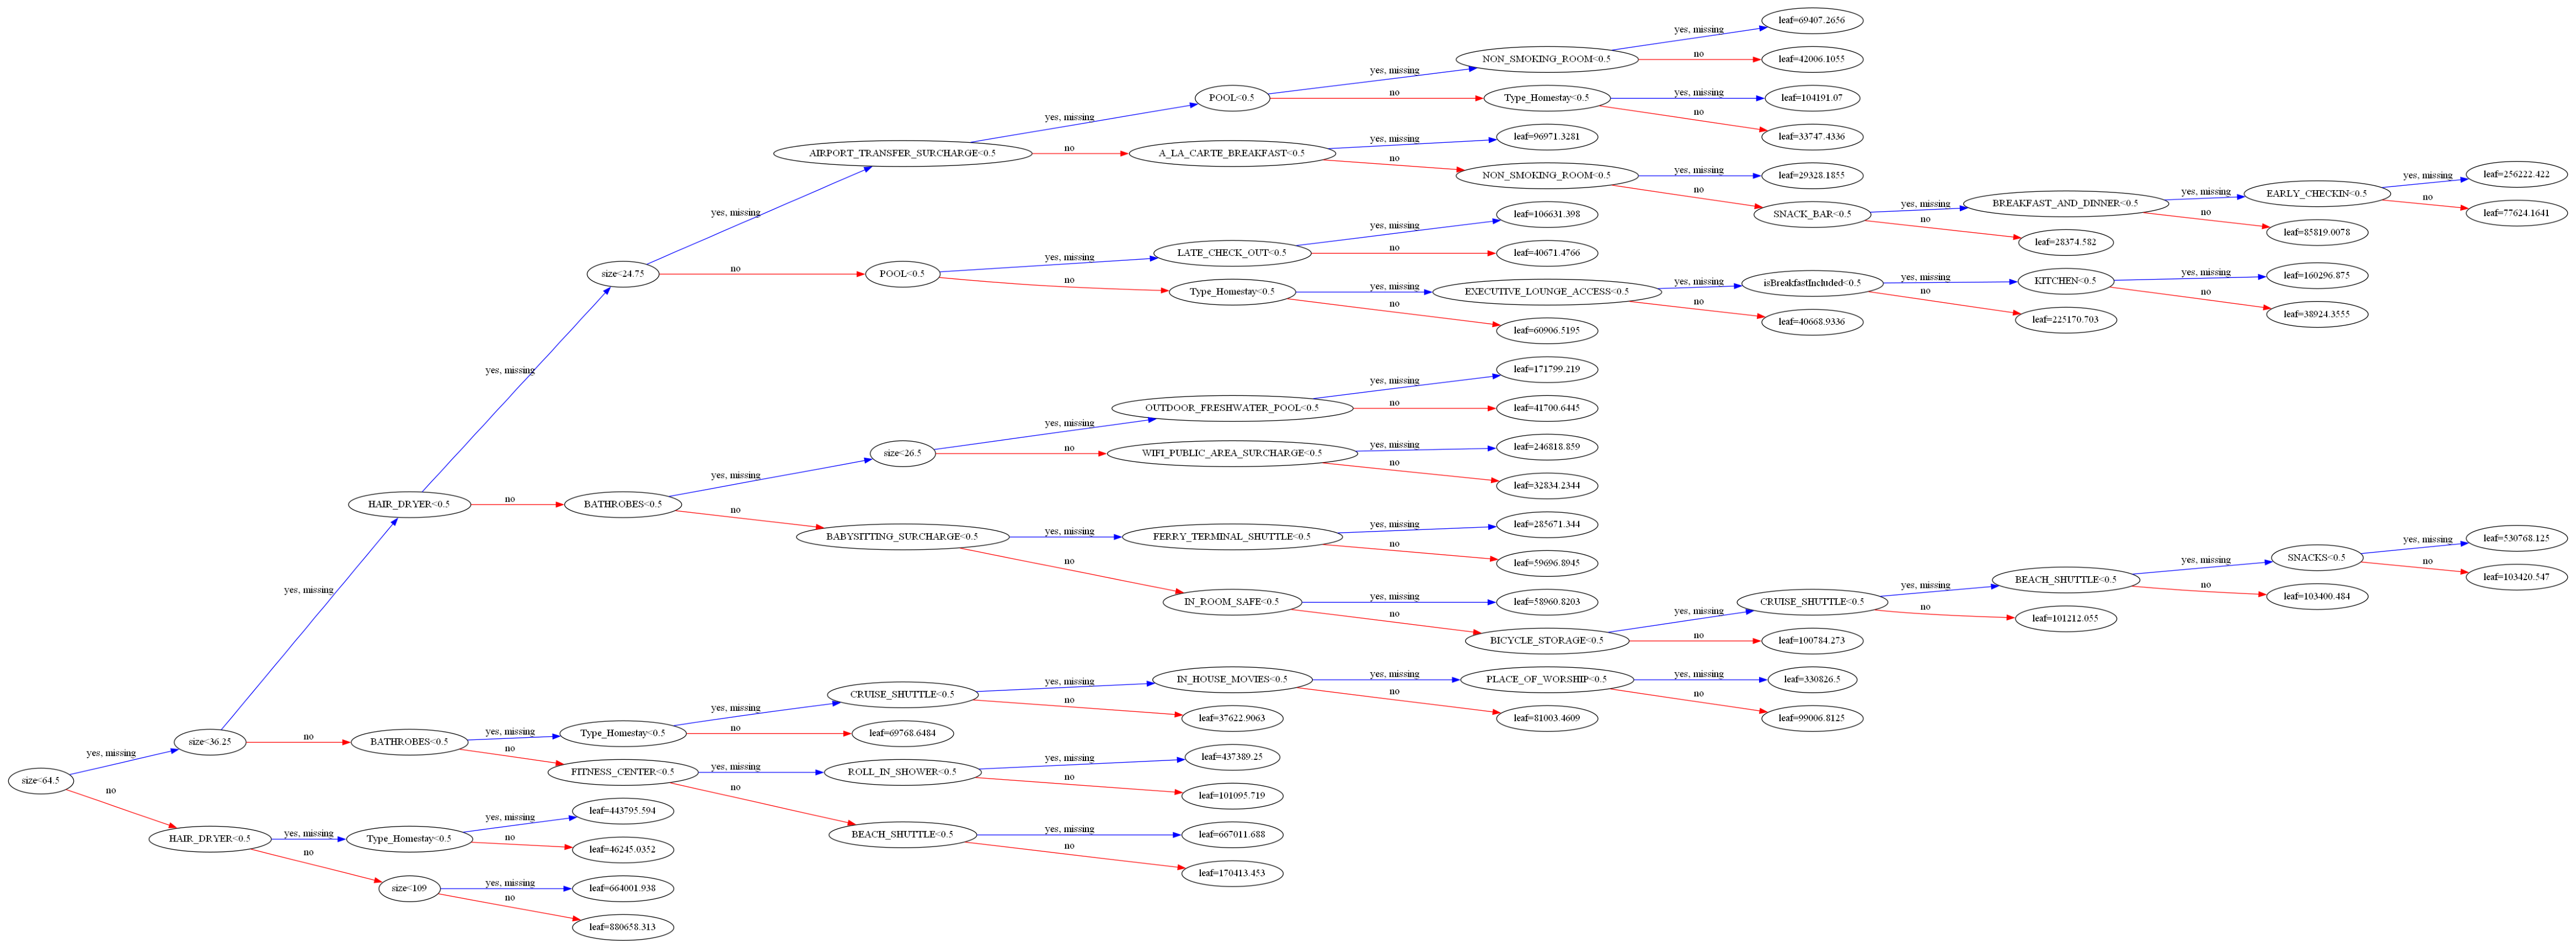

In [13]:
from xgboost import plot_tree

plot_tree(grid.best_estimator_, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(60, 50, forward=True)
plt.savefig('tree.png')